In [ ]:
# ..
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict

In [3]:
# Define constants
ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]  # Stay, Up, Down, Left, Right
ACTION_NAMES = ['Stay', 'Up', 'Down', 'Left', 'Right']
NUM_ACTIONS = len(ACTIONS)
GAMMA = 0.9  # Discount factor
ALPHA = 0.1  # Learning rate
EPSILON = 0.25  # Exploration rate
MAX_EPISODES = 500

# Grid environment size
GRID_SIZE = 10
grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)

# Walls (obstacles)
obstacles = [
    (0, 4), (1, 4), (2, 4), (2, 5), (4, 0),
    (4, 1), (4, 2), (5, 2), (9, 5), (8, 5),
    (7, 5), (7, 4), (4, 9), (4, 8), (4, 7), (5, 7)
]
for obstacle in obstacles:
    grid[obstacle] = 1

# Agent start positions and target destinations
start_positions = [(1, 1), (8, 1), (8, 8), (1, 8)]
goal_positions = [(5, 8), (1, 5), (5, 1), (8, 4)]

# Assign colors for visualization
agent_colors = ['red', 'cyan', 'orange', 'purple']

# Environment

In [7]:
# Environment class for Multi-Agent Pathfinding
class MultiAgentEnvironment:
    def __init__(self, grid, agents, goals):
        self.grid = grid
        self.agents = agents
        self.goals = goals
        self.num_agents = len(agents)
        self.state = tuple(agents)
        self.steps = [0] * self.num_agents

    def is_valid_cell(self, position):
        x, y = position
        return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and self.grid[x, y] != 1

    def reset(self):
        self.state = tuple(start_positions)
        self.steps = [0] * self.num_agents
        return self.state

    def step(self, actions):
        proposed_positions = []
        rewards = []
        collisions = set()

        for i, action in enumerate(actions):
            current_pos = self.state[i]
            move = ACTIONS[action]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if not self.is_valid_cell(next_pos) or next_pos in self.state:
                next_pos = current_pos
            proposed_positions.append(next_pos)

        final_positions = list(self.state)
        for i, next_pos in enumerate(proposed_positions):
            if proposed_positions.count(next_pos) > 1:
                collisions.add(next_pos)
                final_positions[i] = self.state[i]
            else:
                final_positions[i] = next_pos

        new_state = tuple(final_positions)
        for i, next_pos in enumerate(new_state):
            if next_pos == self.goals[i]:
                reward = 10
            elif next_pos in collisions:
                reward = -10
            else:
                reward = -1
            rewards.append(reward)

        self.state = new_state
        done = all(new_state[i] == self.goals[i] for i in range(self.num_agents))
        for i in range(self.num_agents):
            self.steps[i] += 1

        max_steps = max(self.steps)
        return self.state, rewards, done, max_steps

# Training function for multi-agent Q-learning

In [8]:
# Training function for multi-agent Q-learning
def train_agents(env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(env.num_agents)]
    min_max_time = float('inf')
    episode_rewards = []

    for episode in range(MAX_EPISODES):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            actions = []
            for i in range(env.num_agents):
                if np.random.rand() < EPSILON:
                    action = np.random.choice(NUM_ACTIONS)
                else:
                    action = np.argmax(q_tables[i][state[i]])
                actions.append(action)

            next_state, rewards, done, max_time = env.step(actions)

            for i in range(env.num_agents):
                current_q = q_tables[i][state[i]][actions[i]]
                next_max_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][actions[i]] = current_q + ALPHA * (
                    rewards[i] + GAMMA * next_max_q - current_q
                )

            total_reward += sum(rewards)
            state = next_state

        episode_rewards.append(total_reward)
        min_max_time = min(min_max_time, max_time)

    return q_tables, min_max_time, episode_rewards

In [9]:
# Extract optimal paths for visualization
def extract_paths(env, q_tables):
    paths = []
    for i in range(env.num_agents):
        current_pos = start_positions[i]
        path = [current_pos]

        while current_pos != goal_positions[i]:
            action = np.argmax(q_tables[i][current_pos])
            move = ACTIONS[action]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if not env.is_valid_cell(next_pos):
                break

            path.append(next_pos)
            current_pos = next_pos

        paths.append(path)
    return paths

# Visualization of the grid and paths
def plot_grid_with_paths(grid, agents, goals, paths):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(0, GRID_SIZE)

    # Plot obstacles
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if grid[x, y] == 1:
                ax.add_patch(patches.Rectangle((y, GRID_SIZE - x - 1), 1, 1, color='gray'))

    # Plot agents' starting positions and goals
    for idx, (x, y) in enumerate(agents):
        ax.add_patch(patches.Rectangle((y, GRID_SIZE - x - 1), 1, 1, color=agent_colors[idx], alpha=0.6))
    for idx, (x, y) in enumerate(goals):
        ax.plot(
            y + 0.5, GRID_SIZE - x - 1 + 0.5,
            marker='*', color=agent_colors[idx], markersize=15, markeredgewidth=2
        )

    # Plot paths
    for idx, path in enumerate(paths):
        for j in range(1, len(path)):
            x1, y1 = path[j - 1]
            x2, y2 = path[j]
            ax.plot(
                [y1 + 0.5, y2 + 0.5],
                [GRID_SIZE - x1 - 1 + 0.5, GRID_SIZE - x2 - 1 + 0.5],
                color=agent_colors[idx], linewidth=2, linestyle='--'
            )

    # Add grid lines
    for i in range(GRID_SIZE + 1):
        ax.plot([0, GRID_SIZE], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, GRID_SIZE], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Grid World with Optimal Paths", fontsize=16)


# Main

Training completed! Minimum max time: 16
Agent 1 path: [(1, 1), (1, 2), (2, 2), (3, 2), (3, 3), (3, 4), (4, 4), (5, 4), (5, 5), (5, 6), (6, 6), (6, 7), (6, 8), (5, 8)]
Agent 2 path: [(8, 1), (8, 2), (7, 2), (7, 3), (6, 3), (5, 3), (5, 4), (5, 5), (4, 5), (3, 5), (3, 6), (2, 6), (1, 6), (1, 5)]
Agent 3 path: [(8, 8), (7, 8), (7, 7), (7, 6), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (6, 1), (5, 1)]
Agent 4 path: [(1, 8), (1, 7), (2, 7), (3, 7), (3, 6), (4, 6), (4, 5), (4, 4), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4)]


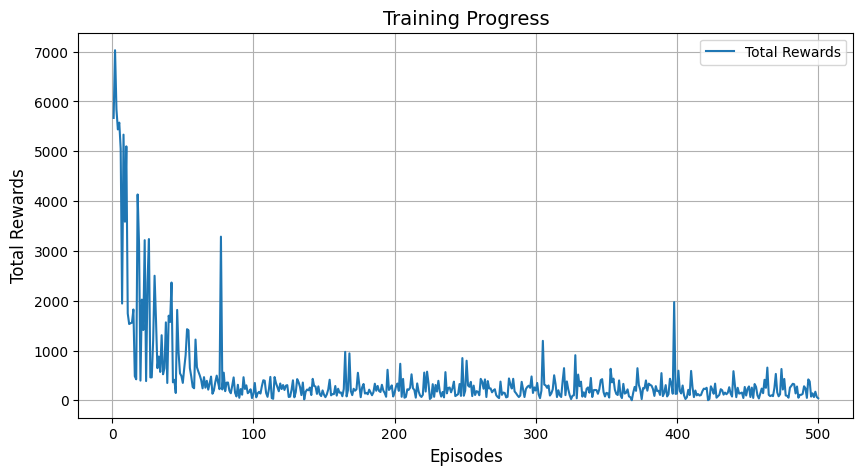

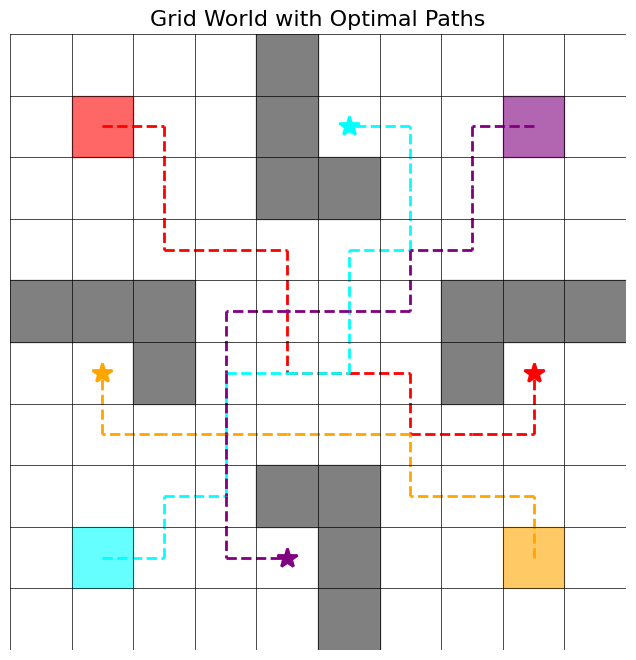

In [10]:
# Main function
if __name__ == "__main__":
    environment = MultiAgentEnvironment(grid, start_positions, goal_positions)

    q_tables, min_max_time, rewards = train_agents(environment)
    print(f"Training completed! Minimum max time: {min_max_time}")
    paths = extract_paths(environment, q_tables)
    for i, path in enumerate(paths):
        print(f"Agent {i + 1} path: {path}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, MAX_EPISODES + 1), rewards, label="Total Rewards")
    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel("Total Rewards", fontsize=12)
    plt.title("Training Progress", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

    plot_grid_with_paths(grid, start_positions, goal_positions, paths)
    plt.show()


In [ ]:
import torch
import random

class SokobanEnvironment:
    def __init__(self, grid_size=(6, 7), box_positions=None, goal_positions=None):
        self.grid_size = grid_size
        self.agent_pos = [0, 0]  # Starting position of the agent
        self.box_positions = box_positions or [[1, 2], [3, 4]]
        self.goal_positions = goal_positions or [[4, 5], [5, 6]]
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.box_positions = [[1, 2], [3, 4]]
        self.state = self._get_state()
        return self.state

    def _get_state(self):
        return tuple(self.agent_pos) + tuple(sum(self.box_positions, []))

    def step(self, action):
        reward = -1
        done = False
        agent_x, agent_y = self.agent_pos

        if action == 'UP':
            new_agent_pos = [agent_x - 1, agent_y]
        elif action == 'DOWN':
            new_agent_pos = [agent_x + 1, agent_y]
        elif action == 'LEFT':
            new_agent_pos = [agent_x, agent_y - 1]
        elif action == 'RIGHT':
            new_agent_pos = [agent_x, agent_y + 1]
        else:
            raise ValueError("Invalid Action")

        if 0 <= new_agent_pos[0] < self.grid_size[0] and 0 <= new_agent_pos[1] < self.grid_size[1]:
            if new_agent_pos in self.box_positions:
                box_idx = self.box_positions.index(new_agent_pos)
                box_new_pos = [
                    new_agent_pos[0] + (new_agent_pos[0] - agent_x),
                    new_agent_pos[1] + (new_agent_pos[1] - agent_y),
                ]
                if (
                    0 <= box_new_pos[0] < self.grid_size[0]
                    and 0 <= box_new_pos[1] < self.grid_size[1]
                    and box_new_pos not in self.box_positions
                ):
                    self.box_positions[box_idx] = box_new_pos
                else:
                    return self._get_state(), reward, done  # Box move invalid
            self.agent_pos = new_agent_pos

        # Check completion
        if all(box in self.goal_positions for box in self.box_positions):
            reward = 0
            done = True
        return self._get_state(), reward, done

    def render(self):
        grid = [['.' for _ in range(self.grid_size[1])] for _ in range(self.grid_size[0])]
        for goal in self.goal_positions:
            grid[goal[0]][goal[1]] = 'G'
        for box in self.box_positions:
            grid[box[0]][box[1]] = 'B'
        agent_x, agent_y = self.agent_pos
        grid[agent_x][agent_y] = 'A'
        for row in grid:
            print(' '.join(row))
        print()


def value_iteration(env, gamma=0.9, theta=1e-6, device="cuda"):
    state_values = {}
    policy = {}

    def get_action_values(state):
        values = {}
        for action in env.actions:
            env.agent_pos, env.box_positions = state[:2], list(map(list, zip(*[iter(state[2:])] * 2)))
            next_state, reward, _ = env.step(action)
            values[action] = reward + gamma * state_values.get(next_state, torch.tensor(0.0, device=device))
        return values

    for x in range(env.grid_size[0]):
        for y in range(env.grid_size[1]):
            state = (x, y) + tuple([0] * (len(env.box_positions) * 2))
            state_values[state] = torch.tensor(0.0, device=device)
            policy[state] = random.choice(env.actions)

    iteration = 0
    while True:
        delta = torch.tensor(0.0, device=device)
        iteration += 1
        for state in state_values.keys():
            action_values = get_action_values(state)
            best_action = max(action_values, key=action_values.get)
            new_value = action_values[best_action]
            delta = max(delta, abs(state_values[state] - new_value))
            state_values[state] = new_value
            policy[state] = best_action
        print(f"Iteration {iteration}: Delta = {delta.item()}")
        if delta < theta:
            print("Value Iteration converged!")
            break
    return policy


def monte_carlo(env, episodes=1000, gamma=0.9, first_visit=True, device="cuda"):
    returns = {}
    state_action_values = {}
    policy = {}

    for episode_num in range(1, episodes + 1):
        episode = []
        state = env.reset()
        while True:
            action = random.choice(env.actions)
            next_state, reward, done = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break

        visited = set()
        G = torch.tensor(0.0, device=device)
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if first_visit and (state, action) in visited:
                continue
            visited.add((state, action))
            returns.setdefault((state, action), []).append(G)
            state_action_values[(state, action)] = torch.tensor(
                torch.mean(torch.tensor(returns[(state, action)], device=device)), device=device
            )
            policy[state] = max(env.actions, key=lambda a: state_action_values.get((state, a), 0))

        # Log progress every 100 episodes
        if episode_num % 100 == 0:
            avg_return = sum([sum(returns[s, a]) for s, a in returns]) / sum([len(returns[s, a]) for s, a in returns])
            print(f"Episode {episode_num}/{episodes}: Average Return = {avg_return:.2f}")

    print("Monte Carlo training complete!")
    return policy


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on device: {device}")

    env = SokobanEnvironment()
    print("Initial Environment:")
    env.render()

    print("\nTraining with Value Iteration...")
    dp_policy = value_iteration(env, device=device)

    print("\nTraining with Monte Carlo (First-Visit)...")
    mc_policy = monte_carlo(env, first_visit=True, device=device)

    print("\nLearned Policies:")
    print("Value Iteration Policy:", dp_policy)
    print("Monte Carlo Policy:", mc_policy)


Running on device: cuda
Initial Environment:
A . . . . . .
. . B . . . .
. . . . . . .
. . . . B . .
. . . . . G .
. . . . . . G


Training with Value Iteration...
Iteration 1: Delta = 1.0
Iteration 2: Delta = 0.8999999761581421
Iteration 3: Delta = 0.8100000619888306
Iteration 4: Delta = 0.7289998531341553
Iteration 5: Delta = 0.6561000347137451
Iteration 6: Delta = 0.5904898643493652
Iteration 7: Delta = 0.5314407348632812
Iteration 8: Delta = 0.47829675674438477
Iteration 9: Delta = 0.4304671287536621
Iteration 10: Delta = 0.3874201774597168
Iteration 11: Delta = 0.3486785888671875
Iteration 12: Delta = 0.3138103485107422
Iteration 13: Delta = 0.28242969512939453
Iteration 14: Delta = 0.25418663024902344
Iteration 15: Delta = 0.22876787185668945
Iteration 16: Delta = 0.20589065551757812
Iteration 17: Delta = 0.1853017807006836
Iteration 18: Delta = 0.16677188873291016
Iteration 19: Delta = 0.15009498596191406
Iteration 20: Delta = 0.1350851058959961
Iteration 21: Delta = 0.121577262

In [ ]:
import random


class SokobanEnvironment:
    def __init__(self, grid_size=(6, 7), box_positions=None, goal_positions=None):
        self.grid_size = grid_size
        self.agent_pos = [0, 0]
        self.box_positions = box_positions or [[1, 2], [3, 4]]
        self.goal_positions = goal_positions or [[4, 5], [5, 6]]
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.reset()

    def reset(self):
        """Reset the environment to the initial state."""
        self.agent_pos = [0, 0]
        self.box_positions = [[1, 2], [3, 4]]
        return self._get_state()

    def _get_state(self):
        """Return a tuple representing the current state."""
        return tuple(self.agent_pos) + tuple(sum(self.box_positions, []))

    def is_valid_move(self, new_pos):
        """Check if the new position is within bounds and not a wall."""
        x, y = new_pos
        return 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1]

    def step(self, action):
        """Take a step in the environment."""
        reward = -1
        done = False
        agent_x, agent_y = self.agent_pos

        if action == 'UP':
            new_agent_pos = [agent_x - 1, agent_y]
        elif action == 'DOWN':
            new_agent_pos = [agent_x + 1, agent_y]
        elif action == 'LEFT':
            new_agent_pos = [agent_x, agent_y - 1]
        elif action == 'RIGHT':
            new_agent_pos = [agent_x, agent_y + 1]
        else:
            raise ValueError("Invalid Action")

        # Check if the agent can move
        if self.is_valid_move(new_agent_pos):
            # Check if a box is in the new position
            if new_agent_pos in self.box_positions:
                box_idx = self.box_positions.index(new_agent_pos)
                box_new_pos = [
                    new_agent_pos[0] + (new_agent_pos[0] - agent_x),
                    new_agent_pos[1] + (new_agent_pos[1] - agent_y),
                ]
                # Check if the box can move
                if self.is_valid_move(box_new_pos) and box_new_pos not in self.box_positions:
                    self.box_positions[box_idx] = box_new_pos
                else:
                    return self._get_state(), reward, done  # Box move invalid
            self.agent_pos = new_agent_pos

        # Check if the puzzle is solved
        if all(box in self.goal_positions for box in self.box_positions):
            reward = 0
            done = True
        return self._get_state(), reward, done

    def render(self):
        """Print the current state of the grid."""
        grid = [['.' for _ in range(self.grid_size[1])] for _ in range(self.grid_size[0])]
        for goal in self.goal_positions:
            grid[goal[0]][goal[1]] = 'G'
        for box in self.box_positions:
            grid[box[0]][box[1]] = 'B'
        agent_x, agent_y = self.agent_pos
        grid[agent_x][agent_y] = 'A'
        for row in grid:
            print(' '.join(row))
        print()


def value_iteration(env, gamma=0.9, theta=1e-6):
    """Solve the Sokoban puzzle using Value Iteration."""
    state_values = {}
    policy = {}

    def get_all_states():
        states = []
        for x in range(env.grid_size[0]):
            for y in range(env.grid_size[1]):
                states.append((x, y))
        return states

    def get_action_values(state):
        values = {}
        for action in env.actions:
            env.agent_pos, env.box_positions = state[:2], list(map(list, zip(*[iter(state[2:])] * 2)))
            next_state, reward, _ = env.step(action)
            values[action] = reward + gamma * state_values.get(next_state, 0)
        return values

    for state in get_all_states():
        state_values[state] = 0
        policy[state] = random.choice(env.actions)

    while True:
        delta = 0
        for state in state_values.keys():
            action_values = get_action_values(state)
            best_action = max(action_values, key=action_values.get)
            new_value = action_values[best_action]
            delta = max(delta, abs(state_values[state] - new_value))
            state_values[state] = new_value
            policy[state] = best_action
        if delta < theta:
            break
    return policy


def monte_carlo(env, episodes=1000, gamma=0.9, first_visit=True):
    """Solve the Sokoban puzzle using Monte Carlo methods."""
    returns = {}
    state_action_values = {}
    policy = {}

    for _ in range(episodes):
        episode = []
        state = env.reset()
        while True:
            action = random.choice(env.actions)
            next_state, reward, done = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break

        visited = set()
        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if first_visit and (state, action) in visited:
                continue
            visited.add((state, action))
            returns.setdefault((state, action), []).append(G)
            state_action_values[(state, action)] = sum(returns[(state, action)]) / len(
                returns[(state, action)]
            )
            policy[state] = max(env.actions, key=lambda a: state_action_values.get((state, a), 0))
    return policy


if __name__ == "__main__":
    env = SokobanEnvironment()
    print("Initial Environment:")
    env.render()

    print("\nTraining with Value Iteration...")
    dp_policy = value_iteration(env)
    print("\nTraining with Monte Carlo (First-Visit)...")
    mc_policy = monte_carlo(env, first_visit=True)

    print("\nLearned Policies:")
    print("Value Iteration Policy:", dp_policy)
    print("Monte Carlo Policy:", mc_policy)

Initial Environment:
A . . . . . .
. . B . . . .
. . . . . . .
. . . . B . .
. . . . . G .
. . . . . . G


Training with Value Iteration...

Training with Monte Carlo (First-Visit)...
